# Importing, Processing, and Exporting Landsat Images

The Landsat program is a series of Earth-observing satellite missions jointly managed by NASA and the U.S. Geological Survey (USGS). Since 1972, Landsat satellites have collected data representing the longest continuous global record of Earth’s surface, enabling people to study many aspects of the planet and to apply that knowledge to a myriad of practical purposes.

### Key Aspects
long-term record, global coverage, high quality suitable for a wide range of applications, free access

### Types of Data

Multispectral Data: visible, near-infrared, and thermal infrared light. Landsat 8 provides data with a spatial resolution of 30 meters in most bands. The Landsat program provides repeated observations of the Earth's surface, allowing changes over time.
Landsat data is radiometrically calibrated.

Applications include land surface mapping, agricultural monitoring, water quality, disaster monitoring, climate change research. 

The Landsat program has been instrumental in advancing our understanding of Earth and in providing crucial data for managing natural resources and guiding environmental policy. With the continuation of the Landsat program through new missions, it is expected to provide valuable data for many more decades to come. 

The USGS Earth Resources Observation and Science (EROS) Center was established before the launch of Landsat 1 (formerly ERTS-1) to become the central repository for Landsat imagery. With over five decades in operation, the EROS Center remains the primary steward of Landsat data and continues to process, distribute, and archive data from the mission. Since 2008, when the USGS signed a free and open data policy, Landsat data have become widely accessible and spurred the development of new data products, tools, and applications. To learn more about Landsat data, explore the topics below.

[Landsat 8 Data Users Handbook](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1574_L8_Data_Users_Handbook-v5.0.pdf)

In [5]:
from IPython.display import IFrame

# Display the PDF
IFrame("https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1574_L8_Data_Users_Handbook-v5.0.pdf", width=900, height=300)


In this example, we look at images from west coast of Greenland. We want to identify faults and sheeted magmatic intrusions emplaced as a part of north Altantic large igneous province around 56 Ma.

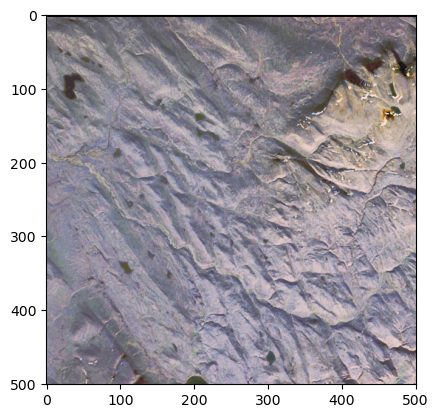

In [17]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from skimage import io
#Import a masked RGB image
I1 = io.imread('dykesimage.tif')
#enhance contrast by transforming the values using contrast-limited adaptive histogram
I1[1,:,:] = exposure.equalize_adapthist(I1[1,:,:],clip_limit=0.1,nbins=256)
I1[2,:,:] = exposure.equalize_adapthist(I1[2,:,:],clip_limit=0.1,nbins=256)
I1[3,:,:] = exposure.equalize_adapthist(I1[3,:,:],clip_limit=0.1,nbins=256)
# convert data to uint8 without rolling the values around the range [0,255]
I2 = exposure.rescale_intensity(I1,out_range='uint8')
# Display the image
plt.imshow(I2)
plt.show()

Name            Shape               Bytes            Type

I1              501 x 501 x 3       1506006          uint16
I2              501 x 501 x 3       753003           uint8
I3              501 x 501           2008008          float64
I4              501 x 501           251001           bool

Upper bound on total bytes  =       4518018


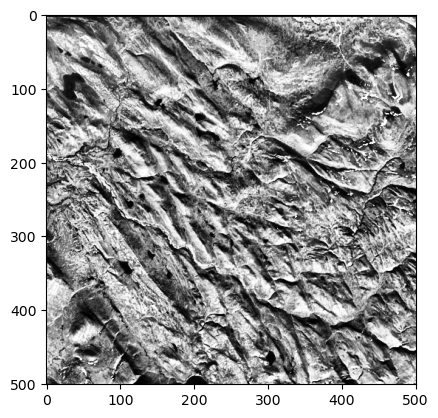

In [18]:
#convert to grayscale and correct contrast
from skimage import color
I3 = color.rgb2gray(I2)
I3 = exposure.equalize_adapthist(I3,clip_limit=0.1,nbins=256)
plt.imshow(I3,cmap='gray')
np.who()

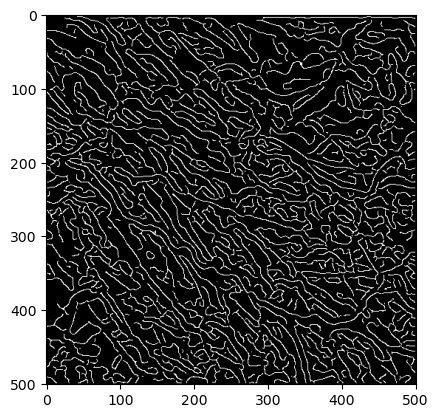

In [101]:
from skimage.feature import canny
I4 = canny(I3,3) #Standard deviation of the Gaussian filter sigma=3
plt.imshow(I4, cmap='gray')
#Finds edges by looking for local maxima of the gradient of I3. 
#The edge function calculates the gradient using the derivative of a Gaussian filter. 
#This method uses two thresholds to detect strong and weak edges, including weak edges in the output
#if they are connected to strong edges. By using two thresholds, the Canny method is less likely 
#than the other methods to be fooled by noise, and more likely to detect true weak edges.

## Hough Transform 

Hough transform is a method to detect lines in an image. After applying an edge detector of any kind, we end up with a binary image that has black pixels on the edges and white pixels in between. We next describe the lines through a given black pixel by using the Euclidean distance $\rho$  between the line and the origin and by using the angle $\theta$ of the vector from the origin to the closest point on the line:

$\rho = x \cos(\theta) + y\sin(\theta)$

The variable $\rho$ is the distance from the origin to the line along a vector perpendicular to the line. $\theta$ is the angle of the perpendicular projection from the origin to the line measured in degrees clockwise from the positive x-axis. The range of theta is –90° ≤ θ < 90°. The angle of the line itself is θ + 90°, also measured clockwise with respect to the positive x-axis.

The results of the transform is a parameter space matrix whose rows and columns correspond to $\rho$ and $\theta$ values respectively. The elements in the transform represent accumulator cells. Initially, the value in each cell is zero. Then, for every non-background point in the image, $\rho$ is calculated for every $\theta$. Peak values in the plot represent potential lines in the input image.


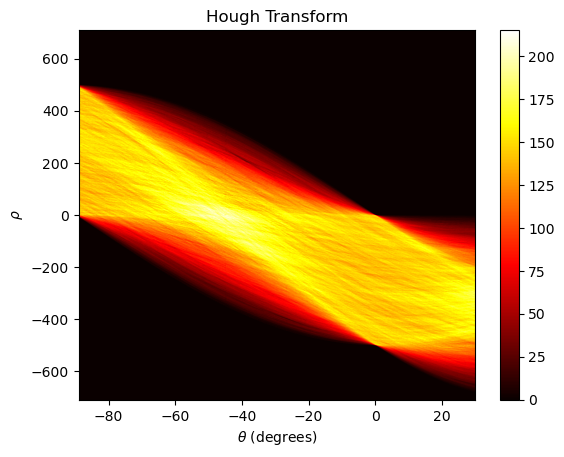

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import hough_line, hough_line_peaks
from scipy.signal import medfilt

# Define the theta range as in MATLAB
theta_range = np.deg2rad(np.arange(-89, 30.1, 0.1))

# Apply the Hough transform
# Hough transform is a method to detect lines in an image
# https://en.wikipedia.org/wiki/Hough_transform
# 
H, theta, rho = hough_line(I4, theta=theta_range)
# Apply median filtering twice
H1 = medfilt(medfilt(H))
# Plot the results
plt.figure()
plt.imshow(H1, cmap='hot', aspect='auto', extent=[np.rad2deg(theta.min()), np.rad2deg(theta.max()), rho.min(), rho.max()])
plt.colorbar()
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\rho$')
plt.title('Hough Transform')
plt.show()

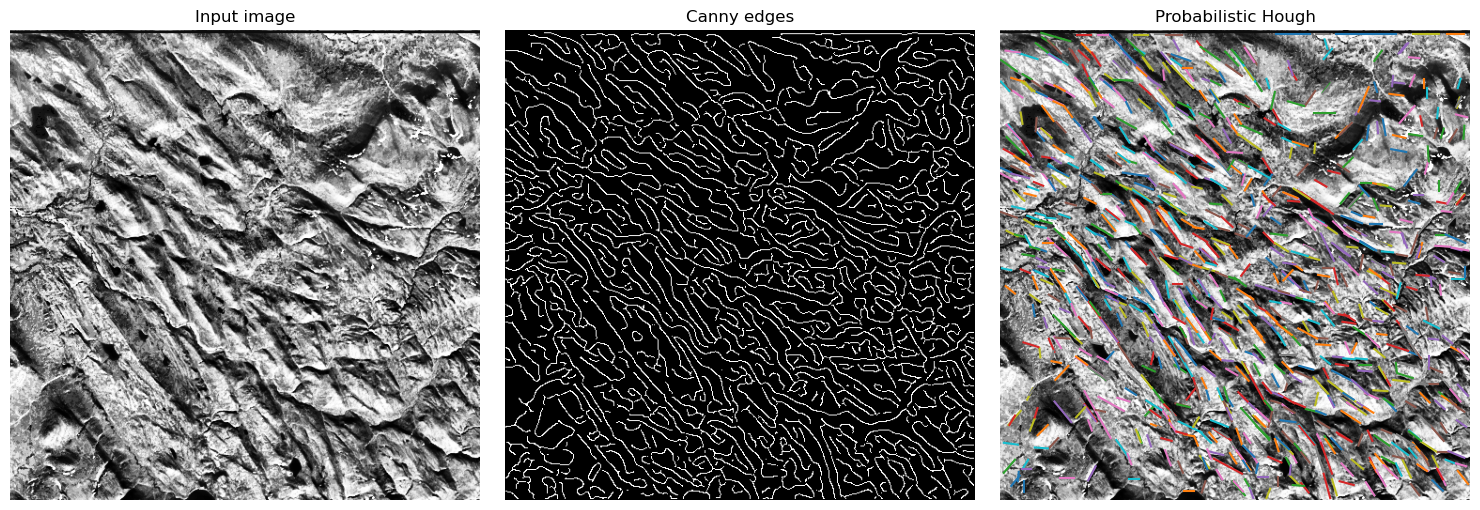

In [94]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform
image = I3
edges = canny(image,3)
lines = probabilistic_hough_line(edges, threshold=10, line_length=10,
                                 line_gap=3, theta= np.linspace(-np.pi / 2, np.pi / 4, 100, endpoint=False) )

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(image, cmap=cm.gray)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()

In [95]:
np.who()

Name                     Shape               Bytes            Type

I1                       501 x 501 x 3       1506006          uint16
I2                       501 x 501 x 3       753003           uint8
I3                       501 x 501           2008008          float64
I4                       501 x 501           251001           bool
theta_range              1191                9528             float64
H                        1419 x 1191         13520232         uint64
theta (theta_range)      1191                9528             float64
rho                      1419                11352            float64
P                        10                  80               uint64
dists                    10                  80               float64
yintcs                   10 x 2              160              float64
slopes                   10                  80               float64
ax                       3                   24               object
H1                       1419 x